In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
import scipy.stats as spstat
import time

from conquer.linear_model import low_dim, high_dim, cv_lambda, validate_lambda

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

rgt.seed(1)

The reference machine used for the simulations below is an iMac with a 3.7 GHz 6-Core Intel i5 processor and 32 GB of RAM. Each simulation exploits only one processor, without any parallelism.

## Model 1

Let $z=(z_1, \ldots, z_p)^T \sim N(0, \Sigma)$ with $\Sigma = (0.5^{|j-k|})_{1\leq j, k \leq p}$. Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =   \langle x_i, \beta^*  \rangle    + 0.7 x_{i1}  \varepsilon_i$, where $x_i = (x_{i1}, \ldots, x_{ip})^T \sim (\Phi(z_1), z_2, \ldots, z_p)^T$, $\varepsilon_i \sim N(0,1)$ are independent of $x_i$, and $\beta^* \in \mathbb R^p$ is sparse with $\beta^*_6 = \beta^*_{12} =\beta^*_{15} = \beta^*_{20} =1$.

Consider two quantile levels: $\tau=0.5$ and $\tau=0.7$. Note that the effect of $x_{i1}$ is only present for $\tau=0.7$.

In [2]:
n, p = 300, 1000
Mu, Sig = np.zeros(p), cov_generate(np.ones(p))
beta = np.zeros(p)
beta[[5, 11, 14, 19]] = 1

M = 100
coef_err = np.zeros(shape=(M,3))
true_pos = np.zeros(shape=(M,3))
false_pos = np.zeros(shape=(M,3))

### Case 1: $\tau=0.5$.

In [3]:
tau = 0.5
true_beta = np.copy(beta)
true_beta[0] = 0.7*spstat.norm.ppf(tau)
true_set = np.where(true_beta!=0)[0]

runtime = np.zeros(3)
for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X.dot(beta) + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    hdsqr = high_dim(X, Y, intercept=False)
    sim_lambda = np.quantile(hdsqr.self_tuning(tau), 0.95)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_model = hdsqr.l1(0.7*sim_lambda, tau)
    runtime[0] += time.time() - tic
    l1_size, l1_set = sum(l1_model['beta'] != 0), np.where(l1_model['beta'] != 0)[0]

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_model = hdsqr.irw(0.7*sim_lambda, tau)
    runtime[1] += time.time() - tic
    irw_size, irw_set = sum(irw_model['beta'] != 0), np.where(irw_model['beta'] != 0)[0]

    ## Oracle conquer
    tic = time.time()
    ora_model = low_dim(X[:,true_set], Y, intercept=False).fit(tau=tau)
    runtime[2] = runtime[2] + time.time() - tic

    coef_err[m,0] = sum((l1_model['beta'] - true_beta)**2)
    coef_err[m,1] = sum((irw_model['beta'] - true_beta)**2)
    coef_err[m,2] = sum((ora_model['beta'] - true_beta[true_set])**2)
    true_pos[m,0] = len(np.intersect1d(true_set, l1_set))
    true_pos[m,1] = len(np.intersect1d(true_set, irw_set))
    true_pos[m,2] = len(true_set)
    false_pos[m,0] = l1_size - true_pos[m,0]
    false_pos[m,1] = irw_size - true_pos[m,1]

In [4]:
out1 = np.array([np.mean(coef_err, axis=0), np.std(coef_err, axis=0), np.mean(true_pos, axis=0), np.mean(false_pos, axis=0), runtime/M])
out1 = pd.DataFrame(out1, columns=['l1-conquer', 'irw-conquer', 'oracle-conquer'],
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out1)
print('\nX1 selection rate:', np.mean(true_pos[:,1]==5))

           l1-conquer  irw-conquer  oracle-conquer
coef err     0.033637     0.001099        0.000977
(std)        0.010807     0.000818        0.000741
true pos     4.000000     4.000000        4.000000
false pos    0.300000     0.050000        0.000000
runtime      0.009531     0.012934        0.001082

X1 selection rate: 0.0


### Case 2: $\tau=0.7$.

In [5]:
tau = 0.7
true_beta = np.copy(beta)
true_beta[0] = 0.7*spstat.norm.ppf(tau)
true_set = np.where(true_beta!=0)[0]

runtime = np.zeros(3)
for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    X[:,0] = spstat.norm.cdf(X[:,0])
    Y = X.dot(beta) + 0.7*X[:,0]*rgt.normal(0,1,size=n)

    hdsqr = high_dim(X, Y, intercept=False)
    sim_lambda = np.quantile(hdsqr.self_tuning(tau), 0.9)
    
    ## l1-penalized conquer (l1 conquer)
    tic = time.time()
    l1_model = hdsqr.l1(0.7*sim_lambda, tau)
    runtime[0] += time.time() - tic
    l1_size, l1_set = sum(l1_model['beta']!=0), np.where(l1_model['beta']!=0)[0]

    ## Iteratively reweighted l1-penalized conquer (IRW-l1 conquer)
    tic = time.time()
    irw_model = hdsqr.irw(0.7*sim_lambda, tau)
    runtime[1] += time.time() - tic
    irw_size, irw_set = sum(irw_model['beta']!=0), np.where(irw_model['beta']!=0)[0]

    ## Oracle conquer
    tic = time.time()
    ora_model = low_dim(X[:,true_set], Y, intercept=False).fit(tau=tau)
    runtime[2] = runtime[2] + time.time() - tic

    coef_err[m,0] = sum((l1_model['beta'] - true_beta)**2)
    coef_err[m,1] = sum((irw_model['beta'] - true_beta)**2)
    coef_err[m,2] = sum((ora_model['beta'] - true_beta[true_set])**2)
    true_pos[m,0] = len(np.intersect1d(true_set, l1_set))
    true_pos[m,1] = len(np.intersect1d(true_set, irw_set))
    true_pos[m,2] = len(true_set)
    false_pos[m,0] = l1_size - true_pos[m,0]
    false_pos[m,1] = irw_size - true_pos[m,1]

In [6]:
out2 = np.array([np.mean(coef_err, axis=0), np.std(coef_err, axis=0), np.mean(true_pos, axis=0), np.mean(false_pos, axis=0), runtime/M])
out2 = pd.DataFrame(out2, columns=['l1-conquer', 'irw-conquer', 'oracle-conquer'], 
                    index=['coef err', '(std)', 'true pos', 'false pos', 'runtime'])
print(out2)
print('\nX1 selection rate:', np.mean(true_pos[:,1]==5))

           l1-conquer  irw-conquer  oracle-conquer
coef err     0.031023     0.005645        0.005364
(std)        0.011839     0.005671        0.005290
true pos     5.000000     5.000000        5.000000
false pos    0.570000     0.030000        0.000000
runtime      0.016693     0.021115        0.002010

X1 selection rate: 1.0


## Model 2

Construct the covariance matrix $\Sigma = (\sigma_j \sigma_k 0.5^{|j-k|})_{1\leq j, k \leq p}$, where $\sigma_1, \ldots, \sigma_p$ are independently generated from Unif$(1,2)$.
Generate independent data vectors $\{(y_i , x_i) \}_{i=1}^n$ from the model $y_i =   \langle x_i, \beta^*  \rangle    +   \varepsilon_i - F_{ \varepsilon_i}^{-1}(\tau)$, where $x_i \sim N(0, \Sigma)$ and $\varepsilon_i \sim t_2$ are independent, and $\beta^* \in \mathbb R^p$ is sparse.

In [2]:
n, p = 256, 1028
tau = 0.75
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
itcp, beta = 4, np.zeros(p)
beta[:15] = [1.6, 0, 1.4, 0, 1.2, 0, 1, 0, -1, 0, -1.2, 0, -1.4, 0, -1.6]
true_set = np.where(abs(beta)>0)[0]
true_loc = np.zeros(p)
true_loc[true_set] = 1

### 2.1. Simulation results for $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

The penality level $\lambda>0$ is determined by a simulation-based method.

In [8]:
M = 100
runtime = np.zeros(3)
itcp_err = np.zeros(shape=(M,3))
coef_err = np.zeros(shape=(M,3))
true_pos = np.zeros(shape=(M,3))
false_pos = np.zeros(shape=(M,3))

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp*np.ones(n) + X.dot(beta)
    err = rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)
    Y += err

    hdsqr = high_dim(X, Y)
    sim_lambda = np.quantile(hdsqr.self_tuning(tau), 0.95)

    ## l1-penalized conquer
    tic = time.time()
    l1_model = hdsqr.l1(tau=tau, Lambda=0.7*sim_lambda)
    runtime[0] += time.time() - tic
    l1_set = np.where( l1_model['beta'][1:]!=0 )[0]

    ## Iteratively reweighted l1-penalized conquer (default is SCAD penality)
    tic = time.time()
    irw_model = hdsqr.irw(tau=tau, Lambda=0.7*sim_lambda)
    runtime[1] += time.time() - tic
    irw_set = np.where( irw_model['beta'][1:]!=0 )[0]
    
    ## Oracle conquer
    tic = time.time()
    sqr = low_dim(X[:,true_set], Y)
    ora_model = sqr.fit(tau=tau)
    runtime[2] += time.time() - tic
    
    itcp_err[m,0], itcp_err[m,1], itcp_err[m,2] = abs(l1_model['beta'][0] - itcp), abs(irw_model['beta'][0] - itcp), abs(ora_model['beta'][0] - itcp)
    coef_err[m,0], coef_err[m,1], coef_err[m,2] = sum((l1_model['beta'][1:] - beta)**2), sum((irw_model['beta'][1:] - beta)**2), sum((ora_model['beta'][1:] - beta[true_set])**2)
    true_pos[m,0] = len(np.intersect1d(true_set, l1_set))
    true_pos[m,1] = len(np.intersect1d(true_set, irw_set))
    true_pos[m,2] = len(true_set)
    false_pos[m,0] = len(np.setdiff1d(l1_set, true_set))
    false_pos[m,1] = len(np.setdiff1d(irw_set, true_set))

In [9]:
out = {'itcp err': np.mean(itcp_err, axis=0), 
       '(itcp std)': np.std(itcp_err, axis=0), 
       'coef err': np.mean(coef_err, axis=0),
       '(coef std)': np.std(coef_err, axis=0),
       'true pos': np.mean(true_pos, axis=0), 
       'false pos': np.mean(false_pos, axis=0), 
       'runtime': runtime/M}
out = pd.DataFrame(out, index=['l1-conquer', 'irw-l1-conquer','oracle'])
out

,itcp err,(itcp std),coef err,(coef std),true pos,false pos,runtime
l1-conquer,0.446215,0.226191,0.728516,0.370922,8.0,3.65,0.024869
irw-l1-conquer,0.101168,0.077942,0.068229,0.065386,8.0,1.76,0.029637
oracle,0.096305,0.072071,0.052596,0.033720,8.0,0.00,0.002249


### 2.2. Solution paths of $\ell_1$- and iteratively reweighted $\ell_1$-penalized conquer

In [10]:
M = 100
nlambda = 40
runtime = np.zeros(2)
l1_sse, l1_tp, l1_fp = np.zeros([nlambda, M]), np.zeros([nlambda, M]), np.zeros([nlambda, M])
irw_sse, irw_tp, irw_fp = np.zeros([nlambda, M]), np.zeros([nlambda, M]), np.zeros([nlambda, M])

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,size=n) - spstat.t.ppf(tau,df=2)

    hdsqr = high_dim(X, Y, intercept=True)
    lambda_max = np.max(hdsqr.self_tuning(tau))
    lambda_seq = np.linspace(0.25*lambda_max, lambda_max, nlambda)

    ## l1-penalized conquer
    tic = time.time()
    l1_model = hdsqr.l1_path(lambda_seq=lambda_seq, tau=tau)
    runtime[0] += time.time() - tic
    
    ## irw-l1-penalized conquer
    tic = time.time()
    irw_model = hdsqr.irw_path(lambda_seq=lambda_seq, tau=tau)
    runtime[1] += time.time() - tic    

    l1_sse[:,m] = np.sum((l1_model['beta_seq'][1:,:] - beta[:,None])**2, axis=0)
    irw_sse[:,m] = np.sum((irw_model['beta_seq'][1:,:] - beta[:,None])**2, axis=0)
    l1_loc = np.sign(abs(l1_model['beta_seq'][1:,:]))
    irw_loc = np.sign(abs(irw_model['beta_seq'][1:,:]))
    l1_tp[:,m] = np.sum(l1_loc*true_loc[:,None], axis=0)
    irw_tp[:,m] = np.sum(irw_loc*true_loc[:,None], axis=0)
    l1_fp[:,m] = np.sum(l1_loc, axis=0) - l1_tp[:,m]
    irw_fp[:,m] = np.sum(irw_loc, axis=0) - irw_tp[:,m]

l1_tot, irw_tot = l1_fp+l1_tp, irw_fp+irw_tp
l1_fdr = np.mean(l1_fp/np.where(l1_tot==0, 1, l1_tot), axis=1)
irw_fdr = np.mean(irw_fp/np.where(irw_tot==0, 1, irw_tot), axis=1)
l1_tpr = np.mean(l1_tp/len(true_set), axis=1)
irw_tpr = np.mean(irw_tp/len(true_set), axis=1)

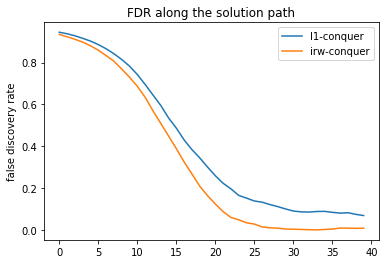

In [11]:
# FDR along the solution path
plt.plot(l1_fdr, label='l1-conquer')
plt.plot(irw_fdr, label='irw-conquer')
plt.title("FDR along the solution path")
plt.ylabel("false discovery rate")
plt.legend()

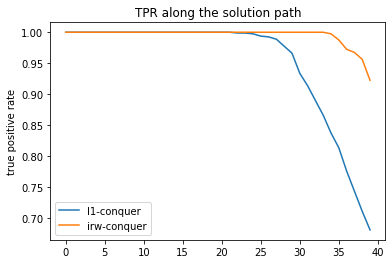

In [12]:
# TPR along the solution path
plt.plot(l1_tpr, label='l1-conquer')
plt.plot(irw_tpr, label='irw-conquer')
plt.title("TPR along the solution path")
plt.ylabel("true positive rate")
plt.legend()

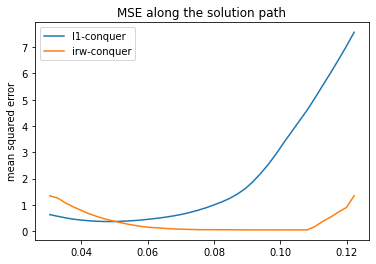

In [13]:
# MSE along the solution path
plt.plot(lambda_seq, np.mean(l1_sse, axis=1), label='l1-conquer')
plt.plot(lambda_seq, np.mean(irw_sse, axis=1), label='irw-conquer')
plt.title("MSE along the solution path")
plt.ylabel("mean squared error")
plt.legend()

### 2.3. Train ($\ell_1$, SCAD, MCP) penalized conquer on a validation set

$\ell_1$-conquer: $\ell_1$-penalized conquer;

scad-conquer: iteratively reweighted $\ell_1$-penalized conquer using SCAD-based weights;

mcp-conquer: iteratively reweighted $\ell_1$-penalized conquer using MCP-based weights;

oracle: conquer estimator fitted on the true model.

In [3]:
n_val = 128
nlambda, M = 40, 100
## [coef_se, model_size, true_pos, false_pos, lambda_min]
metrics = np.zeros(shape=(4,M,5)) 
runtime = np.zeros(4)

for m in range(M):
    X_all = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n+n_val)
    Y_all = itcp + X_all.dot(beta) + rgt.standard_t(2,n+n_val) - spstat.t.ppf(tau,df=2)
    
    # training set of size n
    X, Y = X_all[:n, :], Y_all[:n]
    # validation set of size n_val
    X_val, Y_val = X_all[n:,:], Y_all[n:]
    
    lambda_max = np.max(high_dim(X, Y).self_tuning(tau))
    lambda_seq = np.linspace(lambda_max, 0.25*lambda_max, nlambda)
    hdsqr = validate_lambda(X, Y, X_val, Y_val)
    
    tic = time.time()
    l1_model = hdsqr.train(tau, lambda_seq=lambda_seq, penalty="L1")
    runtime[0] +=  time.time() - tic
    
    tic = time.time()
    scad_model = hdsqr.train(tau, lambda_seq=lambda_seq, penalty="SCAD", a=3.7)
    runtime[1] +=  time.time() - tic
    
    tic = time.time()
    mcp_model = hdsqr.train(tau, lambda_seq=lambda_seq, penalty="MCP", a=3)
    runtime[2] +=  time.time() - tic   
    
    tic = time.time()
    ora_model = low_dim(X[:,true_set], Y).fit(tau=tau)
    runtime[3] += time.time() - tic
    
    err1, err2, err3, err4 = l1_model['val_beta'][1:] - beta, scad_model['val_beta'][1:] - beta, mcp_model['val_beta'][1:] - beta, ora_model['beta'][1:] - beta[true_set]
    # squared L2-error (coefficients)
    metrics[0,m,0], metrics[1,m,0], metrics[2,m,0], metrics[3,m,0] = err1.dot(err1), err2.dot(err2), err3.dot(err3), err4.dot(err4)
    # selected model size
    metrics[0,m,1], metrics[1,m,1], metrics[2,m,1], metrics[3,m,1] = l1_model['val_size'], scad_model['val_size'], mcp_model['val_size'], len(true_set)
    # selected model
    l1_set = np.where( l1_model['val_beta'][1:]!=0 )[0]
    scad_set = np.where( scad_model['val_beta'][1:]!=0 )[0]
    mcp_set = np.where( mcp_model['val_beta'][1:]!=0 )[0]
    # true positives
    metrics[0,m,2] = len(np.intersect1d(true_set, l1_set))
    metrics[1,m,2] = len(np.intersect1d(true_set, scad_set))
    metrics[2,m,2] = len(np.intersect1d(true_set, mcp_set))
    metrics[3,m,2] = len(true_set)
    # false positives
    metrics[0,m,3] = len(np.setdiff1d(l1_set, true_set))
    metrics[1,m,3] = len(np.setdiff1d(scad_set, true_set))    
    metrics[2,m,3] = len(np.setdiff1d(mcp_set, true_set))
    # lambda_min (the value of lambda that gives minimum validation error)
    metrics[0,m,4], metrics[1,m,4], metrics[2,m,4] = l1_model['lambda_min'], scad_model['lambda_min'], mcp_model['lambda_min']

In [4]:
l1_out = {"coef_mse":   np.mean(metrics[0,:,0]),
          "(std)":      np.std(metrics[0,:,0]),
          "model_size": np.mean(metrics[0,:,1]),
          "true_pos":   np.mean(metrics[0,:,2]), 
          "false_pos":  np.mean(metrics[0,:,3]),
          "lambda_min": np.mean(metrics[0,:,4]),
          "runtime":    runtime[0]/M }
scad_out = {"coef_mse":   np.mean(metrics[1,:,0]),
            "(std)":      np.std(metrics[1,:,0]),
            "model_size": np.mean(metrics[1,:,1]),
            "true_pos":   np.mean(metrics[1,:,2]), 
            "false_pos":  np.mean(metrics[1,:,3]),
            "lambda_min": np.mean(metrics[1,:,4]),
            "runtime":    runtime[1]/M }
mcp_out = {"coef_mse":   np.mean(metrics[2,:,0]),
           "(std)":      np.std(metrics[2,:,0]),
           "model_size": np.mean(metrics[2,:,1]),
           "true_pos":   np.mean(metrics[2,:,2]), 
           "false_pos":  np.mean(metrics[2,:,3]),
           "lambda_min": np.mean(metrics[2,:,4]),
           "runtime":    runtime[2]/M }
ora_out = {"coef_mse":   np.mean(metrics[3,:,0]),
           "(std)":      np.std(metrics[3,:,0]),
           "model_size": np.mean(metrics[3,:,1]),
           "true_pos":   np.mean(metrics[3,:,2]), 
           "false_pos":  np.mean(metrics[3,:,3]),
           "lambda_min": np.mean(metrics[3,:,4]),
           "runtime":    runtime[3]/M }
outcome = pd.DataFrame(data=[l1_out, scad_out, mcp_out, ora_out], 
                       index=["l1-conquer", "scad-conquer","mcp-conquer","oracle"])
outcome

,coef_mse,(std),model_size,true_pos,false_pos,lambda_min,runtime
l1-conquer,0.499475,0.180816,50.72,8.0,42.72,0.049304,0.144848
scad-conquer,0.103809,0.062906,10.48,8.0,2.48,0.088303,0.763650
mcp-conquer,0.105935,0.061089,8.81,8.0,0.81,0.096642,0.852305
oracle,0.096597,0.056907,8.00,8.0,0.00,0.000000,0.002118


### 2.4. Cross-validated ($\ell_1$, SCAD, MCP) penalized conquer

In [5]:
nlambda = 40
M = 100

runtime = np.zeros(4)
est_beta = np.zeros([p+1, 4])
cv_err = np.zeros([4, nlambda, M])
# [coef_se, model_size, true_pos, false_pos, lambda_min]
metrics = np.zeros([4, 5, M])

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    hdsqr = high_dim(X, Y, intercept=True)
    lambda_max = np.max(hdsqr.self_tuning(tau))
    lambda_seq = np.linspace(0.25*lambda_max, lambda_max, nlambda)
    bw = hdsqr.bandwidth(tau)
    
    cv_sqr = cv_lambda(X, Y, intercept=True)
    tic = time.time()
    cv_l1 = cv_sqr.fit(tau=tau, h=bw, lambda_seq=lambda_seq, penalty="L1", nfolds=10)
    est_beta[:, 0] = cv_l1['cv_beta']
    runtime[0] +=  time.time() - tic
    
    tic = time.time()
    cv_scad = cv_sqr.fit(tau=tau, h=bw, lambda_seq=lambda_seq, penalty="SCAD", a=3.7, nfolds=10)
    est_beta[:, 1] = cv_scad['cv_beta']
    runtime[1] +=  time.time() - tic
    
    tic = time.time()
    cv_mcp = cv_sqr.fit(tau=tau, h=bw, lambda_seq=lambda_seq, penalty="MCP", a=3, nfolds=10)
    est_beta[:, 2] = cv_mcp['cv_beta']
    runtime[2] +=  time.time() - tic
    
    tic = time.time()
    ora_model = low_dim(X[:,true_set], Y).fit(tau=tau)
    runtime[3] += time.time() - tic
    est_beta[true_set+1, 3] = ora_model['beta'][1:]
    
    est_loc = np.sign(abs(est_beta[1:,:]))
    # squared L2-error (coefficients)
    metrics[:,0,m] = np.sum((est_beta[1:,:] - beta[:,None])**2, axis=0)
    # selected model size
    metrics[:,1,m] = np.sum(est_loc, axis=0)
    # true positives
    metrics[:,2,m] = np.sum(est_loc*true_loc[:,None], axis=0)
    # false positives
    metrics[:,3,m] = metrics[:,1,m] - metrics[:,2,m]
    # lambda_min (the value of lambda that gives minimum mean cross-validated error)
    metrics[0,4,m], metrics[1,4,m], metrics[2,4,m] = cv_l1['lambda_min'], cv_scad['lambda_min'], cv_mcp['lambda_min']
    # CV error
    cv_err[0,:,m], cv_err[1,:,m], cv_err[2,:,m] = cv_l1['cv_err'], cv_scad['cv_err'], cv_mcp['cv_err']

In [6]:
cv_l1 = {"coef_mse": np.mean(metrics[0,0,:]),
         "(std)": np.std(metrics[0,0,:]),
         "model_size": np.mean(metrics[0,1,:]),
         "true_pos": np.mean(metrics[0,2,:]), 
         "false_pos": np.mean(metrics[0,3,:]),
         "lambda_min": np.mean(metrics[0,4,:])}
cv_scad = {"coef_mse": np.mean(metrics[1,0,:]),
           "(std)": np.std(metrics[1,0,:]),
           "model_size": np.mean(metrics[1,1,:]),
           "true_pos": np.mean(metrics[1,2,:]), 
           "false_pos": np.mean(metrics[1,3,:]), 
           "lambda_min": np.mean(metrics[1,4,:])}
cv_mcp = {"coef_mse": np.mean(metrics[2,0,:]), 
          "(std)": np.std(metrics[2,0,:]), 
          "model_size": np.mean(metrics[2,1,:]), 
          "true_pos": np.mean(metrics[2,2,:]), 
          "false_pos": np.mean(metrics[2,3,:]), 
          "lambda_min": np.mean(metrics[2,4,:])}
ora = {"coef_mse": np.mean(metrics[3,0,:]), 
       "(std)": np.std(metrics[3,0,:]),
       "model_size": np.mean(metrics[3,1,:]),
       "true_pos": np.mean(metrics[3,2,:]), 
       "false_pos": np.mean(metrics[3,3,:]), 
       "lambda_min": np.mean(metrics[3,4,:])}
cv_out = pd.DataFrame(data=[cv_l1, cv_scad, cv_mcp, ora], 
                      index=["l1-conquer", "scad-conquer","mcp-conquer","oracle-conquer"])
cv_out

,coef_mse,(std),model_size,true_pos,false_pos,lambda_min
l1-conquer,0.637683,0.306618,35.03,8.0,27.03,0.057073
scad-conquer,0.100168,0.068045,8.72,8.0,0.72,0.095174
mcp-conquer,0.105740,0.076324,8.52,8.0,0.52,0.102464
oracle-conquer,0.086410,0.049677,8.00,8.0,0.00,0.000000


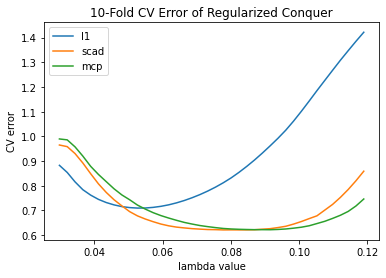

In [7]:
def cv_legend(x, y1, y2, y3):
    plt.clf()
    plt.plot(x,y1,label='l1')
    plt.plot(x,y2,label='scad')
    plt.plot(x,y3,label='mcp')
    plt.title("10-Fold CV Error of Regularized Conquer")
    plt.xlabel("lambda value")
    plt.ylabel("CV error")
    plt.legend()

cv_legend(lambda_seq,
          np.mean(cv_err[0,:,:], axis=1),
          np.mean(cv_err[1,:,:], axis=1),
          np.mean(cv_err[2,:,:], axis=1))

### 2.5. Model selection via Bayesian information criterion

In [8]:
M = 100
estimator = np.zeros([p+1, 3])
# [coef_se, model_size, true_pos, false_pos, bic_lambda]
metrics = np.zeros([3, 5, M])

for m in range(M):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = itcp + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    qr = high_dim(X, Y, intercept=True)
    bic_l1_model   = qr.bic(tau=tau, penalty="L1")
    bic_scad_model = qr.bic(tau=tau, penalty="SCAD")
    bic_mcp_model  = qr.bic(tau=tau, penalty="MCP")

    estimator[:, 0] = bic_l1_model['bic_beta'][:,0]
    estimator[:, 1] = bic_scad_model['bic_beta'][:,0]
    estimator[:, 2] = bic_mcp_model['bic_beta'][:,0]
    err_vector = estimator[1:,:] - beta[:,None] 
    est_loc = np.sign(abs(estimator[1:,:]))
    
    # squared L2-error (coefficients)
    metrics[:,0,m] = np.sum(err_vector**2, axis=0)
    # selected model size
    metrics[:,1,m] = np.sum(est_loc, axis=0)
    # true positives
    metrics[:,2,m] = np.sum(est_loc*true_loc[:,None], axis=0)
    # false positives
    metrics[:,3,m] = metrics[:,1,m] - metrics[:,2,m]
    # lambda_min (the value of lambda that gives minimum BIC)
    metrics[0,4,m], metrics[1,4,m], metrics[2,4,m] = bic_l1_model['bic_lambda'], bic_scad_model['bic_lambda'], bic_mcp_model['bic_lambda']    

In [9]:
table = pd.DataFrame({"coef_mse": np.mean(metrics[:,0,:], axis=1), \
                      "(std)": np.std(metrics[:,0,:], axis=1), \
                      "model_size": np.mean(metrics[:,1,:], axis=1), \
                      "true_pos": np.mean(metrics[:,2,:], axis=1), \
                      "false_pos": np.mean(metrics[:,3,:], axis=1), \
                      "bic_lambda": np.mean(metrics[:,4,:], axis=1)}, index=["l1-bic", "scad-bic","mcp-bic"])
table

,coef_mse,(std),model_size,true_pos,false_pos,bic_lambda
l1-bic,1.741474,0.948699,9.10,7.81,1.29,0.088011
scad-bic,0.086840,0.053142,8.01,8.00,0.01,0.098379
mcp-bic,0.087078,0.052660,8.01,8.00,0.01,0.099878
